In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(4682)

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Kfold cv
from sklearn.model_selection import KFold

# Random forest
from sklearn.ensemble import RandomForestClassifier

# Importing xgboost and shap
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import fbeta_score

import seaborn as sns

# Breast Cancer Winconsin

# Importing data

In [2]:
import os
os.listdir("data/breast_cancer_winconsin")

['breast-cancer-wisconsin.data']

In [3]:
df = pd.read_csv("data/breast_cancer_winconsin/breast-cancer-wisconsin.data", sep=',', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.rename(columns={10: 'outcome'}, inplace=True)

In [5]:
df["outcome"] = df["outcome"].map({4:1.0, 2:0.0})
df.head()

,0,1,2,3,4,5,6,7,8,9,outcome
0,1000025,5,1,1,1,2,1,3,1,1,0.0
1,1002945,5,4,4,5,7,10,3,2,1,0.0
2,1015425,3,1,1,1,2,2,3,1,1,0.0
3,1016277,6,8,8,1,3,4,3,7,1,0.0
4,1017023,4,1,1,3,2,1,3,1,1,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        699 non-null    int64  
 1   1        699 non-null    int64  
 2   2        699 non-null    int64  
 3   3        699 non-null    int64  
 4   4        699 non-null    int64  
 5   5        699 non-null    int64  
 6   6        699 non-null    object 
 7   7        699 non-null    int64  
 8   8        699 non-null    int64  
 9   9        699 non-null    int64  
 10  outcome  699 non-null    float64
dtypes: float64(1), int64(9), object(1)
memory usage: 60.2+ KB


In [7]:
df = df.apply(lambda x : pd.to_numeric(x, errors='coerce'))
df.shape

(699, 11)

In [8]:
df = df.dropna()
df.shape

(683, 11)

In [9]:
os.getcwd()

'/home/ramon/Git/masters_shap'

In [10]:
df_name = './data/' + 'breast_cancer.pkl'
## Saving data
df.to_pickle(df_name)
## Loading and testing
test_df = pd.read_pickle(df_name)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,outcome
0,1000025,5,1,1,1,2,1.0,3,1,1,0.0
1,1002945,5,4,4,5,7,10.0,3,2,1,0.0
2,1015425,3,1,1,1,2,2.0,3,1,1,0.0
3,1016277,6,8,8,1,3,4.0,3,7,1,0.0
4,1017023,4,1,1,3,2,1.0,3,1,1,0.0


# Splitting data

In [11]:
# split data into train and test sets
seed = 7
test_size = 0.33
X = StandardScaler().fit_transform(df.drop('outcome', axis=1))
y = df['outcome'].values
#X_train, X_test, y_train, y_test = train_test_split(X, df.outcome, test_size=test_size, random_state=seed)

### Achieving better performance

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [15]:
y_pred = rf_random.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.90%


In [16]:
model = rf_random.estimator

model.set_params(**rf_random.best_params_)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=60, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=600)

In [17]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.46%


RF Accuracy: 97.37%


Using 341 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/342 [00:00<?, ?it/s]

The max_iter was reached which means the coef_ did not converge


RF Accuracy: 96.48%


Using 342 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/341 [00:00<?, ?it/s]

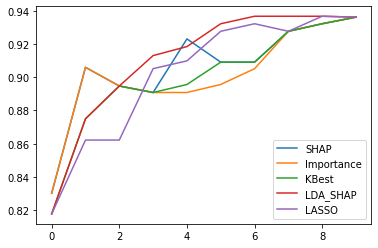

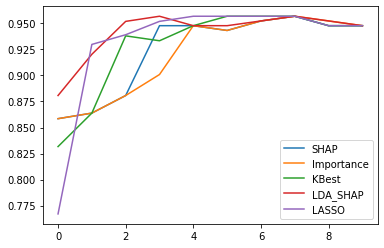

In [29]:
results = []

cv = KFold(n_splits=2, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    features = df.columns[df.columns!='outcome']
    
    # LASSO
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='saga'))
    sel_.fit(X_train, y_train)
    lasso_df = pd.DataFrame(sel_.estimator_.coef_.ravel(), index=df[features].columns, columns=["LASSO"])
    lasso_df.sort_values(by="LASSO", inplace=True, ascending=False)
#     y_pred = sel_.predict(X_test)
#     predictions = [round(value) for value in y_pred]
#     # evaluate predictions
#     accuracy = accuracy_score(y_test, predictions)
#     print("LASSO Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Random Forests
    
    model = RandomForestClassifier() # rf_random.estimator
    model.set_params(**rf_random.best_params_)
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("RF Accuracy: %.2f%%" % (accuracy * 100.0))
    
    
    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)
    #df[features]

    # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
    #shap.force_plot(explainer.expected_value[0], shap_values[0][0], df[features].iloc[0,:], feature_names=features)

    #shap.force_plot(explainer.expected_value[0], shap_values[0], df[features])

    #shap.summary_plot(shap_values[0], df[features])

    # shap.summary_plot(shap_values, df[features], plot_type="bar")

    mean_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
    shap_df = pd.DataFrame(mean_shap_values, index=df[features].columns, columns=["SHAP"])
    shap_df.sort_values(by="SHAP", inplace=True, ascending=False)
    # shap_df.plot(kind="bar")
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    fi_df = pd.DataFrame(dict(zip(features[indices], importances[indices])), index=['Importance'])
    fi_df = fi_df.T
    # fi_df.head()
    # fi_df.plot(kind="bar")
    
    test = SelectKBest(score_func=f_classif, k=X_train.shape[1])
    fit = test.fit(X_train, y_train)
    # summarize scores
    set_printoptions(precision=3)
    # print(fit.scores_)

    kbest_dict = dict(zip(df.drop('outcome', axis=1).columns, fit.scores_))
    kbest_df = pd.DataFrame(kbest_dict, index=['KBest']).transpose()
    kbest_df.sort_values(by='KBest', ascending=False, inplace=True)
    # kbest_df.plot(kind="bar")
    
    # Transforming X from numpy to pandas to recover features
    X_train_df = pd.DataFrame(X_train, columns=df.drop(["outcome"], axis=1).columns)
    X_test_df = pd.DataFrame(X_test, columns=df.drop(["outcome"], axis=1).columns)

    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    lda.fit(X_train_df.values, y_train)
    y_pred = lda.predict(X_test_df)
    # use Kernel SHAP to explain test set predictions
    explainer = shap.KernelExplainer(lda.predict_proba, X_train_df)
    shap_values = explainer.shap_values(X_test, nsamples=100)
    
    # plot the SHAP values for the Setosa output of the first instance
    # shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_df.iloc[0,:], link="logit")

    lda_shap_df = pd.DataFrame(np.mean(np.abs(shap_values[0]), axis=0), index=X_train_df.columns, columns=["LDA_SHAP"])
    lda_shap_df.sort_values(by="LDA_SHAP", ascending=False, inplace=True)
    # lda_shap_df.head()
    # lda_shap_df.plot(kind="bar")
    
    fs_df = pd.DataFrame(list(zip(shap_df.index, fi_df.index, kbest_df.index, lda_shap_df.index, lasso_df.index)), 
                         columns=["SHAP", "Importance", "KBest", "LDA_SHAP", "LASSO"])
    fs_df.head()
    # Initializing dataframe for results
    LDA_scores = pd.DataFrame(index=range(fs_df.shape[0]), columns=fs_df.columns)
    # Filling in LDA scores
    for num_features in range(fs_df.shape[0]):
        fs_df.iloc[:num_features+1]
        for method in fs_df.columns:
            selected_features = fs_df.iloc[:num_features+1][method]
            lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
            y_pred = lda.fit(X_train_df[selected_features].values, y_train).predict(X_test_df[selected_features])
            LDA_scores.loc[num_features, method] = fbeta_score(y_test, y_pred, beta=1)
    
    results.append(LDA_scores)
    LDA_scores.plot()

Text(0.5, 1.0, 'Breast Cancer Winconsin Database')

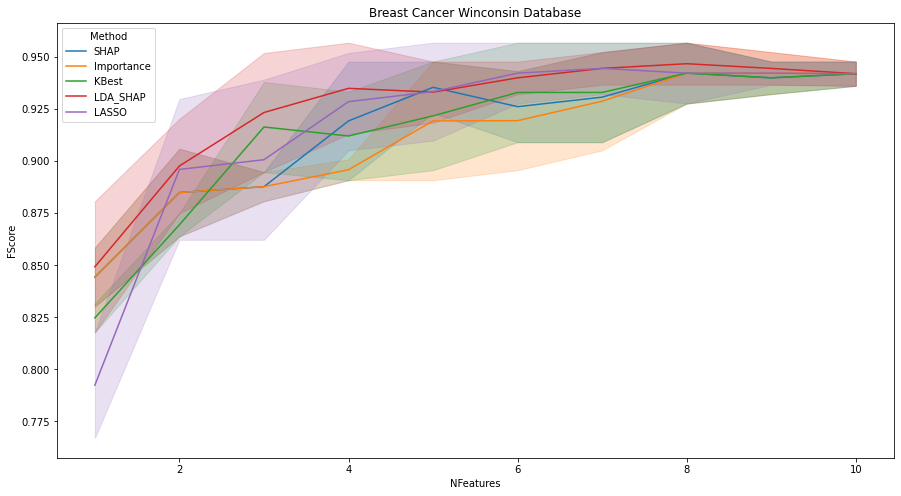

In [30]:
dims = (15, 8)
fig, ax = plt.subplots(figsize=dims)

columns = results[0].columns
CV_LDA_scores = pd.DataFrame(columns=["FScore", "NFeatures", "Method", "Fold"])

for fold, lda_result in enumerate(results):
    for col in columns:
        test_df = pd.DataFrame({"FScore" : lda_result[col],
                                "NFeatures": np.arange(len(lda_result))+1,
                                "Method": [col]*len(lda_result),
                                "Fold": [fold]*len(lda_result)})
        CV_LDA_scores = pd.concat([CV_LDA_scores, test_df])
        
# Asserting data types
CV_LDA_scores.FScore = CV_LDA_scores.FScore.astype(float)
CV_LDA_scores.NFeatures = CV_LDA_scores.NFeatures.astype(int)
# Plot
sns.lineplot(ax=ax, data=CV_LDA_scores, x="NFeatures", y="FScore", hue="Method", ).set_title('Breast Cancer Winconsin Database')

Text(0.5, 1.0, 'Heart Disease Database')

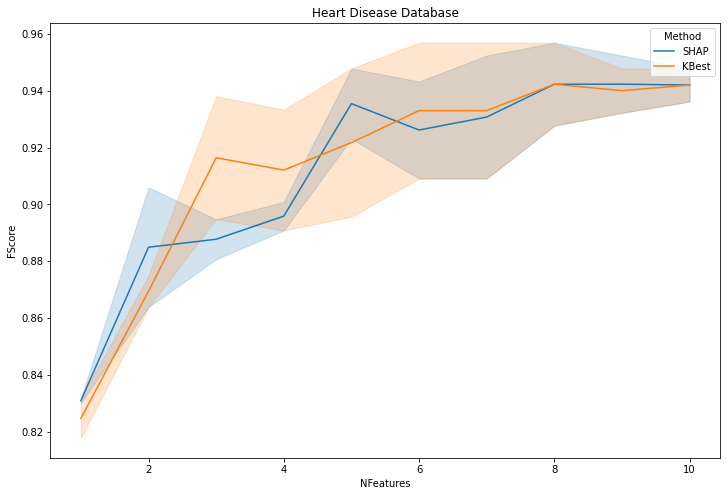

In [23]:
# Plot
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data=CV_LDA_scores[CV_LDA_scores['Method'].isin(['KBest', 'SHAP'])], x="NFeatures", y="FScore", hue="Method").set_title('Heart Disease Database')